# Encoder-only Architecture for Text Classification

Recall that the chief reason for using machine learning models over traditional, lexicon-based sentiment analysis is that like lexicon-based approaches to text classifcation rely on fixed dictionaries, which results in them missing context, irony, or slang. ML models, especially deep learning models, learn complex patterns from data, making them particularly useful for more modern text, such as social media posts and online discussions. 


Generally, for text classification tasks, it is faster to use an encoder-only model like BERT, as we don't need to worry about generating some kind of output sequence- all we are doing is classifying text with some pre-defined labels. In other words, our focus is on *understanding* text rather than *generating* text, so it is both faster, and less computationally expensive, to use encoder-only models like BERT. 

## 0. Data Importing and Cleaning

As mentioned, ML-based text classification works the best for nuanced text with lots of slang. Hence, we'll test it on a dataset of recently-scraped *r/UBC* posts. 


In [165]:
#!pip install transformers # you likely don't have this installed.
#!pip install pytorch # you likely don't have this installed.
# !pip install numpy
# !pip install pandas
# !pip install seaborn

In [166]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import re
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

In [167]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased") # to break our reddit posts down into tokens
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased") # our model

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The reddit dataset is dated around late February 2025, however, you are free to scrape newer posts locally by `cd`-ing into the currect directory and running `python project/docs/4_Advanced/advanced_encoder_classifier/r_ubc_scraper.py` in your terminal. This will generate a fresh new set of post/comment datasets for our analysis.

In [168]:
# Load the dataset
reddit_comments = pd.read_csv('Data/r_ubc_comments.csv')
reddit_posts = pd.read_csv("Data/r_ubc_posts.csv")

In [169]:
# Merging datasets
reddit_data = reddit_posts.merge(reddit_comments.groupby("post_id")["body"].apply(lambda x: " ".join(x)), left_on="id", right_on ='post_id', how="left")
reddit_data["full_text"] = reddit_data['title'] + ['    '] + reddit_data["selftext"].fillna('') + ['    '] + reddit_data["body"].fillna('')

In [170]:
# Convert from UTC to detailed month, date, day of week and hour
reddit_data['created_utc'] = pd.to_datetime(
    reddit_data['created_utc'], 
    unit='s',  # Timestamp is in seconds
    utc=True    # Enforce UTC timezone
)

reddit_data['month'] = reddit_data['created_utc'].dt.month_name() 
reddit_data['date'] = reddit_data['created_utc'].dt.day            
reddit_data['day_of_week'] = reddit_data['created_utc'].dt.day_name()  
reddit_data['hour'] = reddit_data['created_utc'].dt.hour    

def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()                         
        text = re.sub(r"http\S+", "", text)         
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
        return text.strip()                         
    else:
        return ""                      

reddit_data["clean_text"] = reddit_data["full_text"].apply(clean_text)       

## 1. Labelling using a pre-trained BERT model

Here we used a pre-trained model from hugging face to generate sentiment labels for each posts. Specifically, we'll be using `bert-base-uncased`, a model pre-trained on a variety of english texts. 

Notice that for posts without texts we mark them as "neutral".

In [171]:


emotion_classifier = pipeline("text-classification", model="google-bert/bert-base-uncased")

reddit_data["sentiment"] = reddit_data["full_text"].apply(lambda x: emotion_classifier(x[:512])[0]["label"] if pd.notna(x) else "neutral")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device set to use cpu


In [172]:
reddit_data = reddit_data.rename(columns = {'sentiment': 'label', 'clean_text': 'text'})
print(reddit_data.columns.values)

['id' 'title' 'author' 'selftext' 'score' 'num_comments' 'created_utc'
 'url' 'body' 'full_text' 'month' 'date' 'day_of_week' 'hour' 'text'
 'label']


In [173]:
reddit_data.to_csv('Data/r_reddit_data.csv', index=False)

In [174]:
dataset = load_dataset("csv", data_files="Data/r_reddit_data.csv")['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [175]:
# Split training and testing data
split_dataset = dataset.train_test_split(
    test_size=0.2,   
    seed=42                
)

train_data = split_dataset["train"]
test_data = split_dataset["test"]

In [176]:

# Check the distribution of labels from the training set
train_labels = pd.Series(train_data["label"])
print("Training Set:\n",train_labels.value_counts(normalize=True))

# Check the distribution of labels from the testing set
test_labels = pd.Series(test_data["label"])
print("Testing Set:\n",test_labels.value_counts(normalize=True))

Training Set:
 LABEL_1    1.0
Name: proportion, dtype: float64
Testing Set:
 LABEL_1    1.0
Name: proportion, dtype: float64


We can visualize the share of different labels with a pie chart.

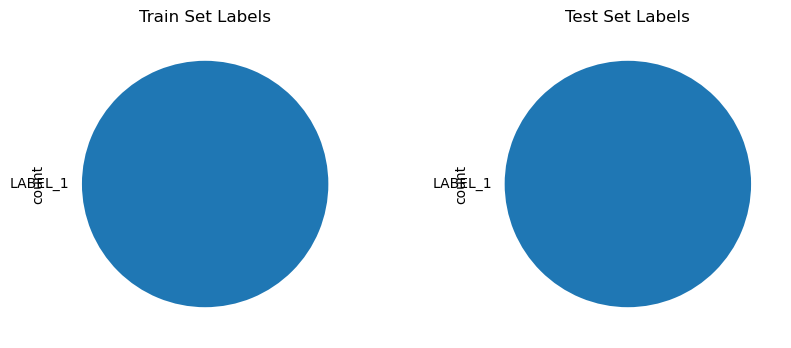

In [177]:
# Visualizing label distribution

train_counts = pd.Series(train_data["label"]).value_counts()
test_counts = pd.Series(test_data["label"]).value_counts()

# Plot the Pie Chart
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
train_counts.plot.pie(title="Train Set Labels")
plt.subplot(1,2,2)
test_counts.plot.pie(title="Test Set Labels")
plt.show()

## Training Classifier

### 1. OneVsRestClassifier

This is our first classifying strategy, which consists in fitting one binary classifier per class.

For example, if you want to classify 3 types of fruits, apple, banana and orange with this strategy, you will need to train 3 binary classifiers. The first of these classifiers determines if it is an apple, the second is responsible for determining if it is a banana, and the third is responsible for determining if it is an orange.

The 3 classifiers will then vote for the given new observation, the voting result will be shown as probability. Let's say we have a new observation that we are unsure what type of fruit it is, so we feed this observation to our classifier. The "Apple" classifier claims it's 80% likely an apple, the "Banana" classifier claims it's 10% likely a banana, and the "Orange" classifier claims it's 50% likely an orange. Then we classify based on the highest probability that our new object is an apple.

While it is simple and effective, this strategy has its drawback -- What if there are large amount of labels for us to classify? What if the labels have specific hierarchies? In the first situation, it may take a lot of time to train multiple classifiers for this task; and in the second situation, we could make a lot of mistakes using binary classification. Then we'd better use alternative strategies. 

Anyhow, this is a good way to begin encoder classification.

### 2. MultiOutputClassifier 

### 3. ClassifierChain

Here, we will show how to train a basic encoder for our purposes using an example. Before we begin, we need to install the necessary package.
```bash
$ pip install setfit
```

In [178]:

torch.cuda.empty_cache()

training_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.version.cuda)
print(torch.__version__)

None
2.6.0


In [179]:
# Set RAM distribution strategy
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("PYTORCH_CUDA_ALLOC_CONF:", os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

PYTORCH_CUDA_ALLOC_CONF: expandable_segments:True


In [180]:
from setfit import SetFitModel
# model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Here we use a pre-trained model for classification, you can also find other models on https://huggingface.co/ 
model = SetFitModel.from_pretrained(model_id, device="cpu", max_seq_length=256)

model.model_head

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


LogisticRegression()

In [181]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=256)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])



/home/user/mambaforge/envs/comet/lib/python3.13/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',              
    num_train_epochs=3,                  
    per_device_train_batch_size=16,         
)


/home/user/mambaforge/envs/comet/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [183]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [184]:
training_args.batch_eval_metrics = True
# Initialize the Trainer with the provided datasets, model, and tokenizer
setattr(training_args, 'full_determinism', False)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
)

preds = model.predict(test_data['text'])

/tmp/ipykernel_124044/399229300.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


AttributeError: 'SetFitModel' object has no attribute 'forward'

In [ ]:
metrics = trainer.evaluate()

metrics

***** Running evaluation *****


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Save our model
model.save_pretrained("./my_setfit_model")

SafetensorError: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "请求的操作无法在使用用户映射区域打开的文件上执行。" })

After saving our first model, we need to check the quality of the data.

A counfusion matrix analysis may be informative. You may need to install the following package
```bash
$ pip install seaborn
```

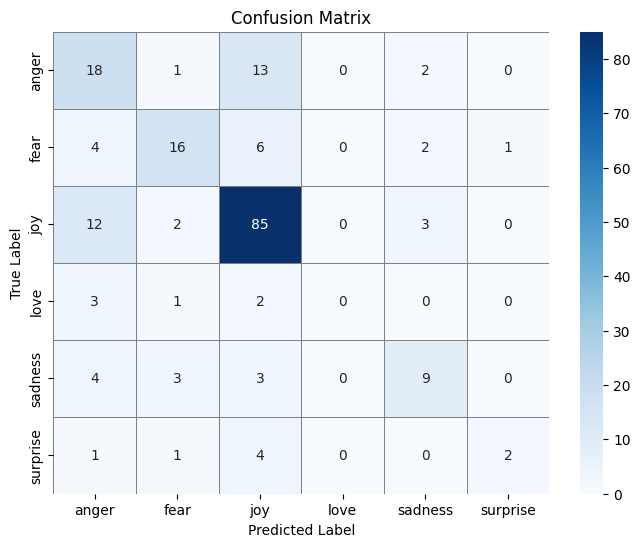

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
y_true = test_data["label"]
y_pred = model.predict(test_data["text"])

# sort labels
classes = sorted(set(y_true)) 

cm = confusion_matrix(y_true, y_pred, labels=classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="gray", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       anger       0.43      0.53      0.47        34
        fear       0.67      0.55      0.60        29
         joy       0.75      0.83      0.79       102
        love       0.00      0.00      0.00         6
     sadness       0.56      0.47      0.51        19
    surprise       0.67      0.25      0.36         8

    accuracy                           0.66       198
   macro avg       0.51      0.44      0.46       198
weighted avg       0.64      0.66      0.64       198



c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

By looking at this confusion matrix and the classification report, we now realize a key disadvantage of our current model lies in correctly classifying anger.

Another way of checking is to look at the baseline model accuracy 

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")
dummy.fit(train_data["text"], train_data["label"])
baseline_acc = dummy.score(test_data["text"], test_data["label"])
print(f'Baseline Model Accuracy: {baseline_acc:.4f}')

Baseline Model Accuracy: 0.3485


In our case, we see the baseline model accuracy is 0.3889, therefore, our training model made about 0.27 accuracy improvement from the base model.

## Reference